# Equivalence demonstration

Investigating how AR models can be viewed as a special case within the broader framework of Expected Signature (ES) models, highlighting the method’s versatility in capturing varied model structures.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from esig import tosig
from sklearn.linear_model import Lasso
import time

## Functions needed

In [2]:
# Function to compute the AR series
def generate_AR_series(n, phi):
    """
    Generates an autoregressive (AR) series of length n using the specified AR parameters.

    Parameters:
    - n: The length of the series to be generated.
    - phi: A list of AR parameters, where phi[0] is the intercept and phi[1:] are the AR coefficients.

    Returns:
    - r: Generated AR series of length n.
    """
    # Determine the order of the AR process (p is the number of AR terms)
    p = len(phi) - 1
    
    # Initialize the series with zeros
    r = np.zeros(n)
    
    # Set a seed for reproducibility of the random noise
    np.random.seed(42)
    
    # Generate random noise from a normal distribution
    noise = np.random.normal(size=n)
    
    # Set the initial value of the AR series to be equal to the first value of the error term
    r[0] = noise[0]

    # Initialize the first p values of the AR series
    for i in range(1, p + 1):
        # Get the past values needed for the current computation
        past_values = r[:i]
        # Compute the value of the series at the current time step using the AR parameters and past values
        r[i] = np.sum(phi[-i:] * past_values) + noise[i]
   
    # Generate the remaining values of the AR series
    for t in range(p, n):
        # Compute the value of the series at time step t using the AR parameters and past values
        r[t] = phi[0] + sum(phi[i] * r[t - i] for i in range(1, p + 1)) + noise[t]
       
    return r

# Function to compute the expected AR series
def generate_expected_AR_series(phi, ar_series):
    """
    Generates an expected series based on the AR parameters and an existing AR series.

    Parameters:
    - phi: List of AR parameters.
    - ar_series: Existing AR series.

    Returns:
    - expected_series: Generated expected series.
    """
    p = len(phi) - 1   # e.g. p is 3 for AR(3) with parameters [phi_0, phi_1, phi_2, phi_3]
    
    # Initialize the series with the same length as the AR series
    expected_series = np.zeros(len(ar_series))
    
    # Copy initial values from the AR series
    expected_series[:p] = ar_series[:p]

    # Generate the series
    for t in range(p, len(ar_series)):
        # Get past values from the expected series (instead of the AR series)
        past_values = ar_series[t - p:t]
        # Compute the next value in the series using AR parameters and past values
        expected_series[t] = phi[0] + sum(phi[i] * past_values[-i] for i in range(1, p + 1))
    
    return expected_series


In [3]:

def AR_calibration(ar_series, expected_ar_series, p):
    """
    Calibrates an Autoregressive (AR) model.

    Parameters:
    - ar_series: The input time series data for the AR model.
    - expected_ar_series: The expected future values for the AR model.
    - p: The number of past observations to use for predicting the future value.

    Returns:
    - y_test: Actual values for the test data.
    - y_test_exp: Expected values for the test data.
    - y_pred: Predicted values for the test data.
    - running_time: Time taken to run the calibration.
    - num_predictors: Number of predictors used in the model.
    """
    start_time = time.time()
    n = len(ar_series)
    train_size = int(0.8 * n)
    train_data, test_data, test_data_exp = ar_series[:train_size], ar_series[train_size:], expected_ar_series[train_size:] 
    X_train, y_train = [], []
    for i in range(p, len(train_data)):
        X_train.append(train_data[i-p:i])
        y_train.append(train_data[i])
    
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Print the number of predictors
    num_predictors = X_train.shape[1]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict on test data
    X_test, y_test_exp, y_test = [], [], []
    for i in range(p, len(test_data)):
        X_test.append(test_data[i-p:i])
        y_test_exp.append(test_data_exp[i])
        y_test.append(test_data[i])
    
    X_test, y_test, y_test_exp = np.array(X_test), np.array(y_test), np.array(y_test_exp)
    y_pred = model.predict(X_test)
    
    end_time = time.time()
    running_time = end_time - start_time
    return y_test, y_test_exp, y_pred, running_time, num_predictors

In [4]:
def calculate_metrics(yhat, y, num_predictors):
    """
    Calculate and evaluation metrics

    Parameters:
    - yhat (array-like): Predicted values.
    - y (array-like): Actual values.
    - num_predictors (int): Number of predictors in the model (excluding the error term).

    Returns:
    tuple: A tuple containing R-squared, Adjusted R-squared, and Mean Squared Error.
    """
    N = len(y)

    # Calculate R-squared (coefficient of determination)
    r2 = r2_score(y, yhat)

    # Calculate Adjusted R-squared
    adjusted_r2 = 1 - (1 - r2) * (N - 1) / (N - num_predictors - 1)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y, yhat)

    # Return R-squared, Adjusted R-squared, and MSE
    return r2, adjusted_r2, mse



In [5]:
# Function to compute the truncated signature
def compute_signature(path, order):
    """
    Computes the truncated signature for a given path.

    Parameters:
    - path: Path or trajectory data.
    - order: The order of the truncated signature.

    Returns:
    - signature: Truncated signature of the path.
    """
    return tosig.stream2sig(path, order)


In [6]:
import warnings
from sklearn.exceptions import ConvergenceWarning
# Function for ES calibration
def ES_calibration(data, expected_data, p, q, n, m):
    """
    Calibrates a model using the Elastic Net method.

    Parameters:
    - data: The input time series data.
    - expected_data: The expected future values for the input data.
    - p: Number of past samples to consider.
    - q: Number of future samples to predict.
    - n: Order of the truncated signature for the past path.
    - m: Order of the truncated signature for the future path.

    Returns:
    - y_test_real: Actual values for the test data.
    - y_test_exp: Expected values for the test data.
    - yhat_test: Predicted values for the test data.
    - running_time: Time taken to run the calibration.
    - num_predictors: Number of predictors used in the model.
    """
    
    starting_time = time.time()
    X_sig, y_sig = [], []
    
    # Iterate through the training data
    for t in range(p, len(data) - q):
        # Generate past path data
        past_path = np.column_stack((np.arange(t - p, t + 1), data[t - p:t + 1]))
        new_row = np.array([[t - p - 1, 0]])
        past_path = np.vstack((new_row, past_path))

        ###########
        # Maintain value at each time interval
        past_path_with_time = []
        for i in range(len(past_path) - 1):
            start_time, start_value = past_path[i]
            end_time, _ = past_path[i + 1]
            past_path_with_time.append([start_time, start_value])
            past_path_with_time.append([end_time, start_value])  # Maintain the value until just before the next time point
        past_path_with_time.append(past_path[-1].tolist())
        past_path_with_time = np.array(past_path_with_time)
        
        # Compute signature for past path
        past_signature = compute_signature(past_path_with_time, n)
        ##########
        # Compute signature for past path
        #past_signature = compute_signature(past_path, n)
        
        # Generate future path data
        future_path = np.column_stack((
            [t - 1, t, t + 1],
            [0, data[t], data[t + 1]]
        ))
        ############
        # Maintain value at each time interval
        future_path_with_time = []
        for i in range(len(future_path) - 1):
            start_time, start_value = future_path[i]
            end_time, _ = future_path[i + 1]
            future_path_with_time.append([start_time, start_value])
            future_path_with_time.append([end_time, start_value])  # Maintain the value until just before the next time point
        future_path_with_time.append(future_path[-1].tolist())
        future_path_with_time = np.array(future_path_with_time)
        
        # Compute signature for future path
        future_signature = compute_signature(future_path_with_time, m)
        ###########
        # Compute signature for future path
        #future_signature = compute_signature(future_path, m)
        
        # Append signatures to X_sig and y_sig
        X_sig.append(past_signature)
        y_sig.append(future_signature)
        

    X_sig, y_sig = np.array(X_sig), np.array(y_sig)
    
    # Split data into training and testing sets
    train_size = int(0.8 * len(X_sig))
    X_sig_train, y_sig_train = X_sig[:train_size], y_sig[:train_size]
    X_sig_test, y_sig_test = X_sig[train_size:], y_sig[train_size:]

    # Print the number of predictors
    num_predictors = X_sig.shape[1]
    
    # Ignore convergence warnings
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    
    # Train the Lasso model
    lasso = Lasso(alpha=0.01, max_iter=10000)
    lasso.fit(X_sig_train, y_sig_train)

    # Make predictions for training and testing data
    y_sig_train_pred = lasso.predict(X_sig_train)
    yhat_train = y_sig_train_pred[:, 2]
    
    yhat_sig_test = lasso.predict(X_sig_test)
    yhat_test = yhat_sig_test[:, 2]
    
    # Extract actual values for testing data
    y_test_exp = expected_data[-(len(X_sig)-train_size):]
    y_test_real = data[-(len(X_sig)-train_size):]
    y_train = expected_data[p + 1: train_size+p+1]
    
    ending_time = time.time()
    running_time = ending_time - starting_time
    return y_test_real, y_test_exp, yhat_test, running_time, num_predictors



## Experiment

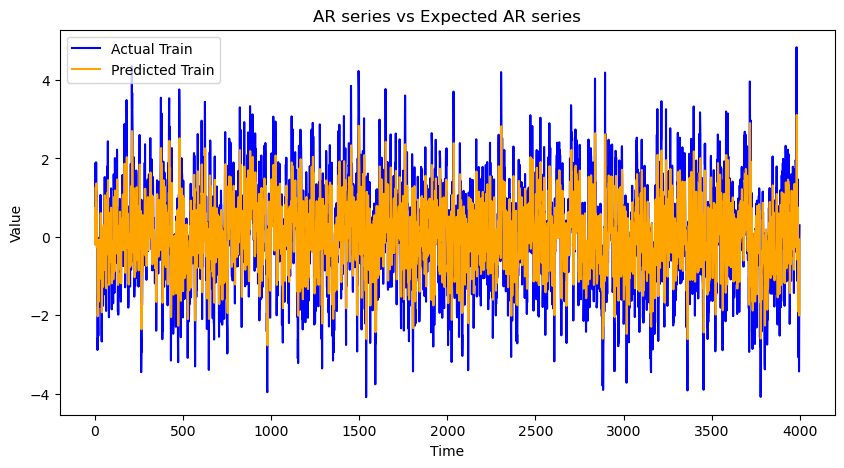

In [7]:
# AR(3) model parameters
phi = [0, 0.6, 0.15, -0.1]

# Generate real time series with and without noise
n = 4000
ar_series = generate_AR_series(n, phi)
expected_ar_data = generate_expected_AR_series(phi, ar_series)


# Plot train dataset
plt.figure(figsize=(10, 5))
plt.plot(ar_series, label='Actual Train', color='blue')
plt.plot(expected_ar_data, label='Predicted Train', color='orange')
plt.title('AR series vs Expected AR series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


# ES calibration parameters
p, q, n, m = 3, 1, 4, 2




### Comparison with expected values

Comparison with expected values:
ES Calibration Metrics against expected values: R2: 0.9956, Adjusted R2: 0.9954, MSE: 0.0033, Running Time: 1.9080
AR Calibration Metrics: R2 against expected values: 0.9990, Adjusted R2: 0.9990, MSE: 0.0008, Running Time: 0.0000


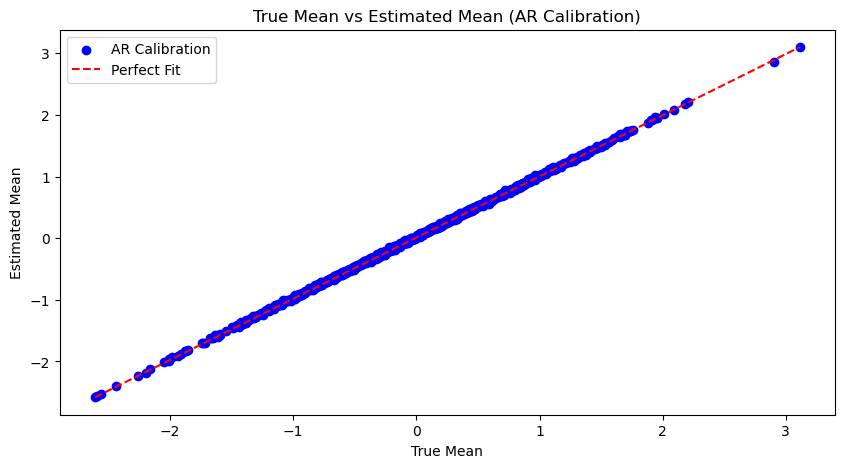

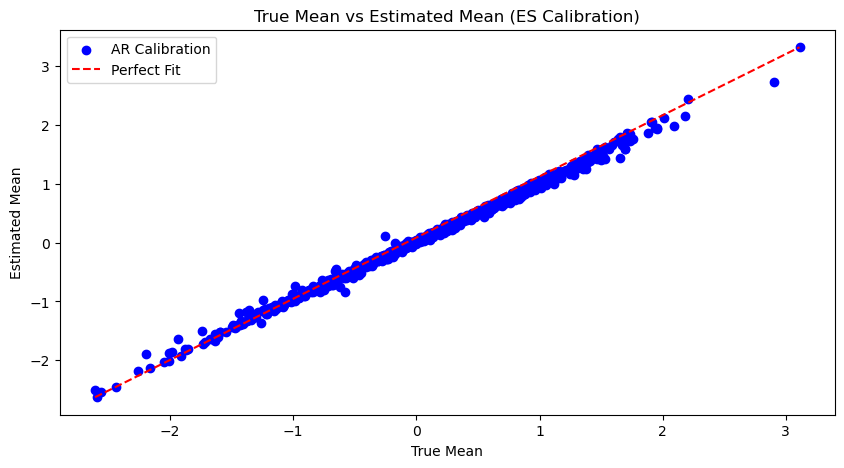

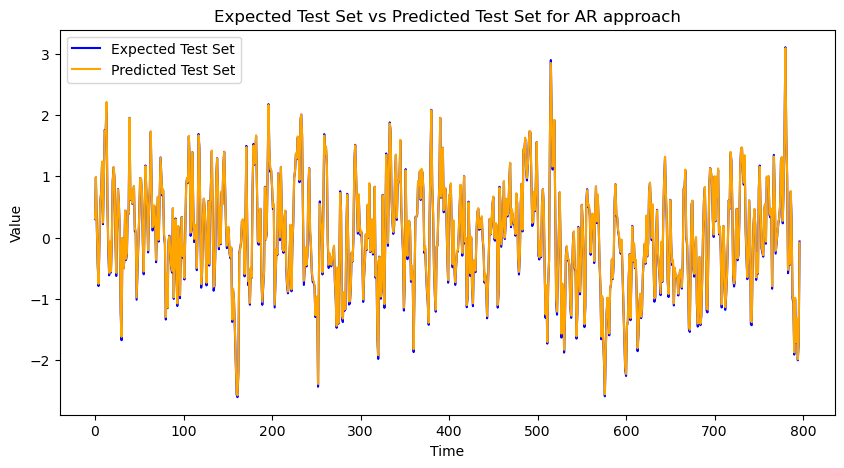

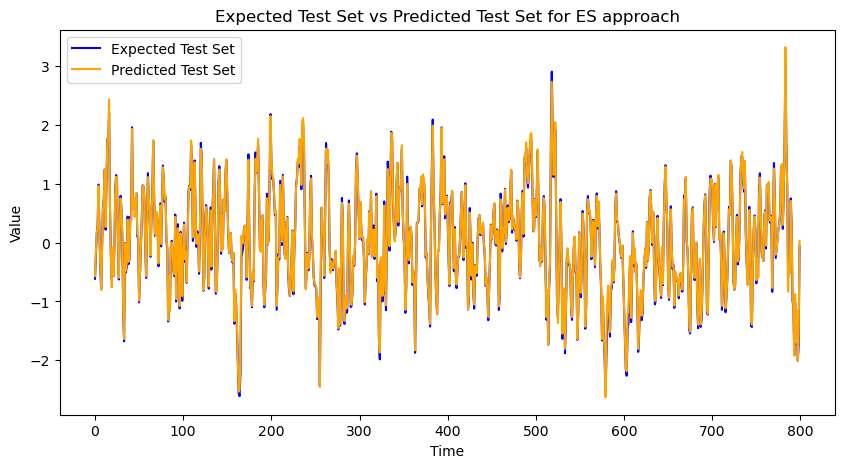

In [8]:
# Execute ES calibration
y_test_es, y_test_exp_es, yhat_test_es, time_es, num_es = ES_calibration(ar_series, expected_ar_data, p, q, n, m)

# Execute AR calibration
y_test_ar, y_test_exp_ar, yhat_test_ar, time_ar, num_ar = AR_calibration(ar_series, expected_ar_data, p)

# Comparison with expected values
print("Comparison with expected values:")

r2_es_exp, adjusted_r2_es_exp, mse_es_exp = calculate_metrics(yhat_test_es, y_test_exp_es, num_es)
print(f"ES Calibration Metrics against expected values: R2: {r2_es_exp:.4f}, Adjusted R2: {adjusted_r2_es_exp:.4f}, MSE: {mse_es_exp:.4f}, Running Time: {time_es:.4f}" )

r2_ar_exp, adjusted_r2_ar_exp, mse_ar_exp = calculate_metrics(yhat_test_ar, y_test_exp_ar, num_ar)
print(f"AR Calibration Metrics: R2 against expected values: {r2_ar_exp:.4f}, Adjusted R2: {adjusted_r2_ar_exp:.4f}, MSE: {mse_ar_exp:.4f}, Running Time: {time_ar:.4f}")


# PLOT MEANS
plt.figure(figsize=(10, 5))
plt.scatter(y_test_exp_ar, yhat_test_ar, color='blue', label='AR Calibration')
plt.plot([min(y_test_exp_ar), max(y_test_exp_ar)], [min(yhat_test_ar), max(yhat_test_ar)], color='red', linestyle='--', label='Perfect Fit')
plt.title('True Mean vs Estimated Mean (AR Calibration)')
plt.xlabel('True Mean')
plt.ylabel('Estimated Mean')
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.scatter(y_test_exp_es, yhat_test_es, color='blue', label='AR Calibration')
plt.plot([min(y_test_exp_es), max(y_test_exp_es)], [min(yhat_test_es), max(yhat_test_es)], color='red', linestyle='--', label='Perfect Fit')
plt.title('True Mean vs Estimated Mean (ES Calibration)')
plt.xlabel('True Mean')
plt.ylabel('Estimated Mean')
plt.legend()
plt.show()

# PLOT OVERLAP
plt.figure(figsize=(10, 5))
plt.plot(y_test_exp_ar, label='Expected Test Set', color='blue')
plt.plot(yhat_test_ar, label='Predicted Test Set', color='orange')
plt.title('Expected Test Set vs Predicted Test Set for AR approach')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(y_test_exp_es, label='Expected Test Set', color='blue')
plt.plot(yhat_test_es, label='Predicted Test Set', color='orange')
plt.title('Expected Test Set vs Predicted Test Set for ES approach')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()





### Comparison with real values

Comparison with real values (with noise):
ES Calibration Metrics against real values: R2: 0.39, Adjusted R2: 0.36, MSE: 1.0664, Running Time: 1.9
AR Calibration Metrics R2 against real values: 0.39, Adjusted R2: 0.39, MSE: 1.0633, Running Time: 0.00


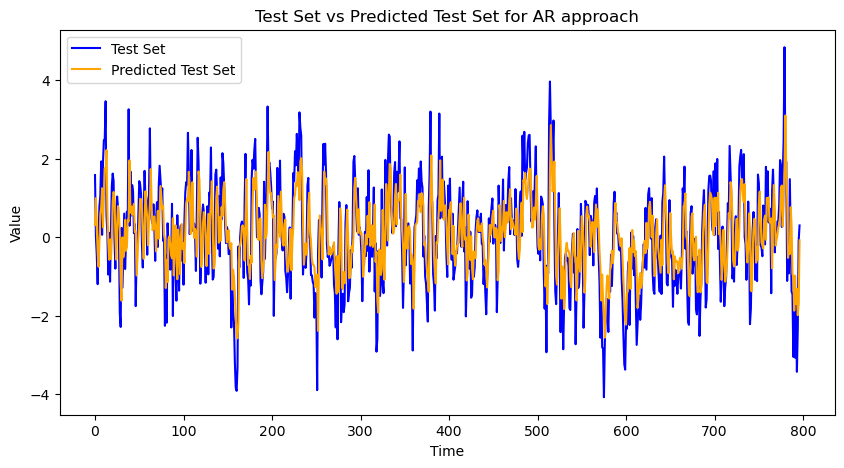

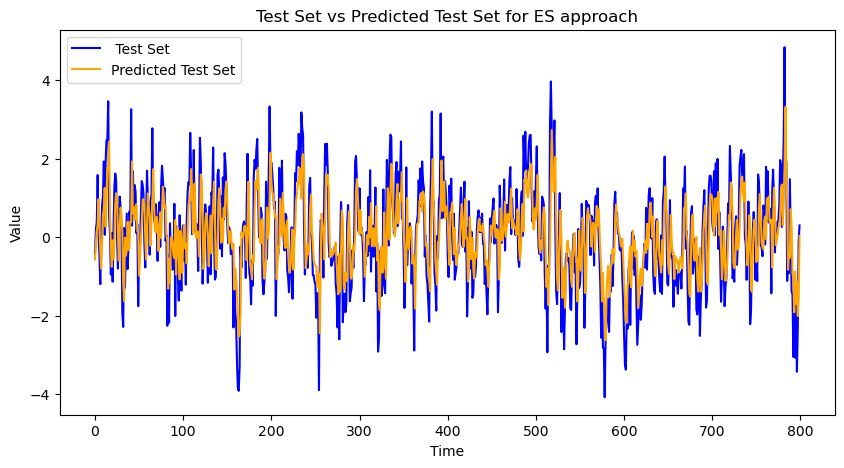

In [9]:
print("Comparison with real values (with noise):")
r2_es, adjusted_r2_es, mse_es = calculate_metrics(yhat_test_es, y_test_es, num_es)
print(f"ES Calibration Metrics against real values: R2: {r2_es:.2f}, Adjusted R2: {adjusted_r2_es:.2f}, MSE: {mse_es:.4f}, Running Time: {time_es:.2}" )

r2_ar, adjusted_r2_ar, mse_ar = calculate_metrics(yhat_test_ar, y_test_ar, num_ar)
print(f"AR Calibration Metrics R2 against real values: {r2_ar:.2f}, Adjusted R2: {adjusted_r2_ar:.2f}, MSE: {mse_ar:.4f}, Running Time: {time_ar:.2f}")

# PLOT OVERLAP
plt.figure(figsize=(10, 5))
plt.plot(y_test_ar, label='Test Set', color='blue')
plt.plot(yhat_test_ar, label='Predicted Test Set', color='orange')
plt.title('Test Set vs Predicted Test Set for AR approach')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y_test_es, label=' Test Set', color='blue')
plt.plot(yhat_test_es, label='Predicted Test Set', color='orange')
plt.title('Test Set vs Predicted Test Set for ES approach')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()